<a href="https://colab.research.google.com/github/mr-nudo/neuronModels1/blob/master/syde552_file_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE 552 Assignment 2: Vision
### Due Monday, February 19, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
- Sustained Ganglion Cells
- Transient Ganglion Cells
- Simple Cells

Cones : Feature detected : Light, Receptive Field : Retina, How they are connected to other neurons:

Vision is mediated by four kinds of photoreceptors in the retina. The light sensitivities of these receptors de!ne the visible spectrum. The photopigments
in rods and cones detect electromagnetic energy of wavelengths that span the range 390 to 670 nm

Sustained Ganglion Cells : Feature detected : Light, Receptive Field : Retina, How they are connected to other neurons:


Transient Ganglion Cells : Feature detected : Light, Receptive Field : Retina, How they are connected to other neurons:

**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset

In [2]:
import torchvision
mnist = torchvision.datasets.MNIST(root='.', download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 80099626.71it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32165611.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24986149.73it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13294158.25it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

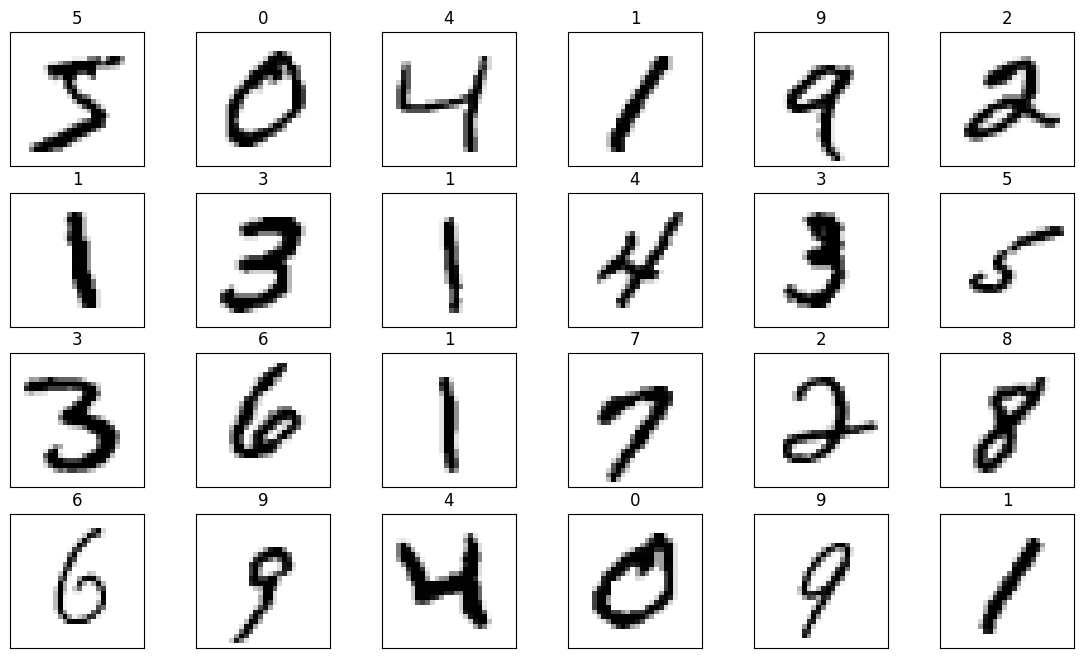

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?


In [4]:
import torch

X = mnist.data.reshape((60000,28*28)).float()/255

T = torch.nn.functional.one_hot(mnist.targets).float()

I = torch.eye(784).float()
lambd = 1

W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)

N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing

Y_train = X_train @ W
Y_test = X_test @ W

accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)

*Question : Do we expect the testing accuracy to be larger or smaller than the training accuracy? Why?*

Answer : The training accuracy is expected to be larger than the testing accuracy. Reason being that the training data is 50,000 less than the testing data. This gives room for less accuracy on the testing data - i.e Overfitting.



**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-4}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-4, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
- Why does changing `lambd` affect the accuracy?  
- Why would having a large `lambd` value be good for making a biologically realistic model?

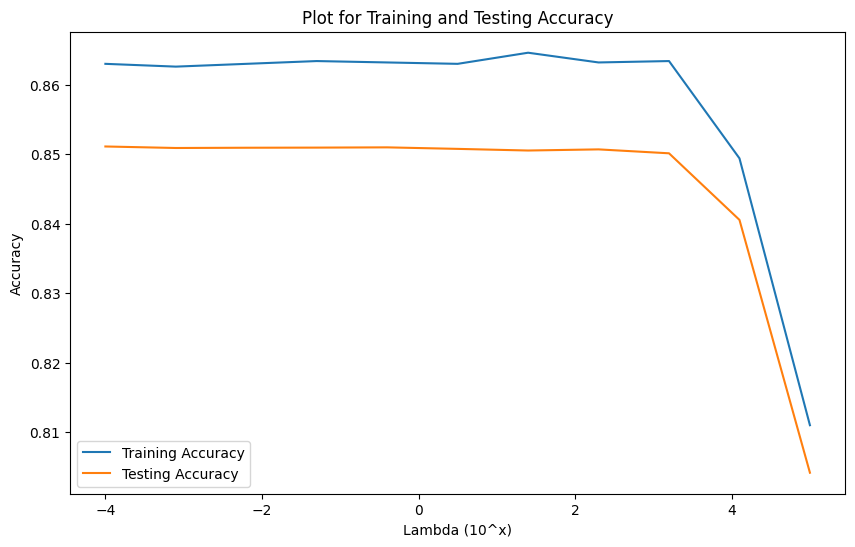

In [5]:
import torch
import numpy as np

X = mnist.data.reshape((60000,28*28)).float()/255

T = torch.nn.functional.one_hot(mnist.targets).float()

I = torch.eye(784).float()

accuracy_train_arry = []
accuracy_test_arry = []
N = 5000
lambds = np.logspace(-4, 5, 11)

for lambd in lambds:
    W = torch.inverse(X.T @ X + lambd * I) @ (X.T @ T)

    X_train, X_test = X[:N], X[N:] # split X into two parts for training and testing
    T_train, T_test = T[:N], T[N:] # split T into two parts for training and testing

    Y_train = X_train @ W
    Y_test = X_test @ W

    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)).item() / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)).item() / len(Y_test)

    accuracy_train_arry.append(accuracy_train)
    accuracy_test_arry.append(accuracy_test)

# Plots
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambds), accuracy_train_arry, label='Training Accuracy')
plt.plot(np.log10(lambds), accuracy_test_arry, label='Testing Accuracy')
# plt.plot(lambds, accuracy_train_arry, label='Training Accuracy')
# plt.plot(lambds, accuracy_test_arry, label='Testing Accuracy')
plt.xlabel('Lambda (10^x)')
plt.ylabel('Accuracy')
plt.title('Plot for Training and Testing Accuracy')
plt.legend()
plt.show()

*Question : What is the best value for lambd (ie the value for which we get the best training accuracy).*

In [6]:
# Answer :
best_lambd = lambds[np.argmax(accuracy_train_arry)]
print(f"The best value of lambd, for which we get the best training accuracy is: {best_lambd}")

The best value of lambd, for which we get the best training accuracy is: 25.11886431509582


*Question : Why does changing lambd affect the accuracy?*

Answer : Changing the value of lambda affects the accuracy because it influences the other constituents of the model like the bias and variance.


*Question : Why would having a large lambd value be good for making a biologically realistic model?*

Answer : For making a biologically realistic model, having a large lambda value would be good because it encourages simplicity and avoids overfitting.

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

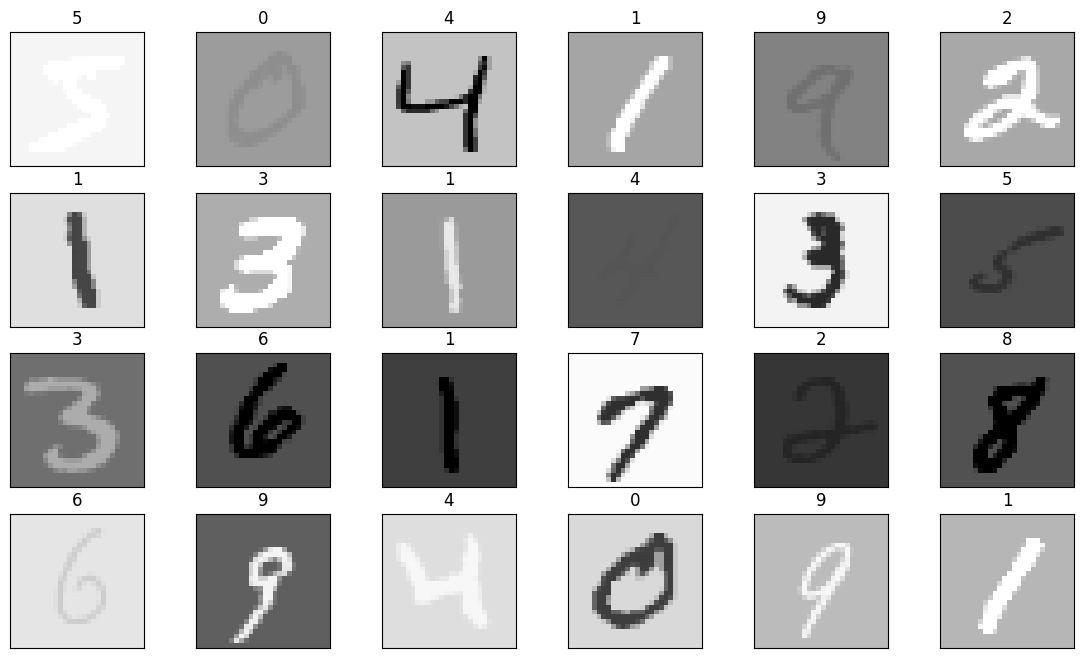

In [7]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

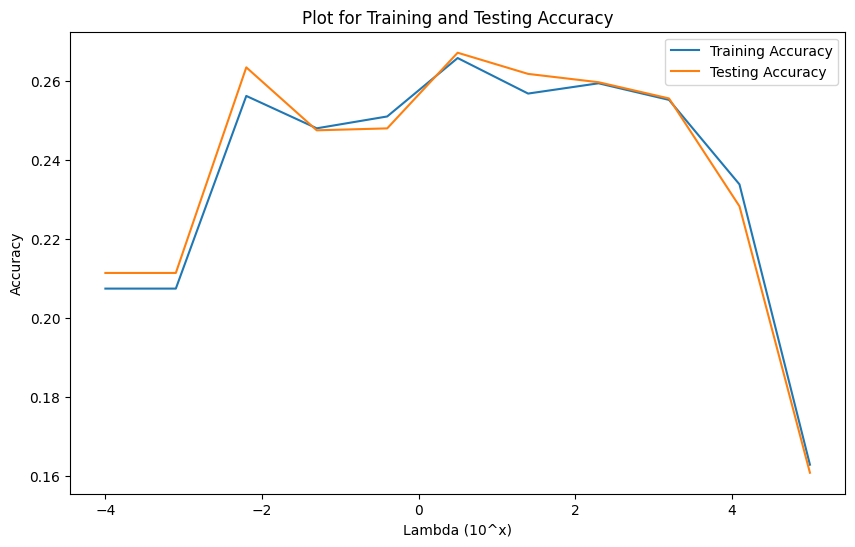

In [8]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

T = torch.nn.functional.one_hot(mnist.targets).float()

I = torch.eye(784).float()

accuracy_train_arry = []
accuracy_test_arry = []
N = 5000
lambds = np.logspace(-4, 5, 11)

for lambd in lambds:
    W = torch.pinverse(X.T @ X + lambd * I) @ (X.T @ T)

    X_train, X_test = X[:N], X[N:] # split X into two parts for training and testing
    T_train, T_test = T[:N], T[N:] # split T into two parts for training and testing

    Y_train = X_train @ W
    Y_test = X_test @ W

    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)).item() / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)).item() / len(Y_test)

    accuracy_train_arry.append(accuracy_train)
    accuracy_test_arry.append(accuracy_test)

# Plots
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambds), accuracy_train_arry, label='Training Accuracy')
plt.plot(np.log10(lambds), accuracy_test_arry, label='Testing Accuracy')
plt.xlabel('Lambda (10^x)')
plt.ylabel('Accuracy')
plt.title('Plot for Training and Testing Accuracy')
plt.legend()
plt.show()

*Question : Is this a harder or easier task than with the original dataset?*

Answer : Yes. Especially with the randomness and logically needing to apply an inverse


*Question : Is this new dataset more like the data at the retina or like the data in the ganglion cells?*

Answer : Retina

*Question : Is the original dataset more like the data at the retina or like the data in the ganglion cells?*

Answer : Ganglion cells.


**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

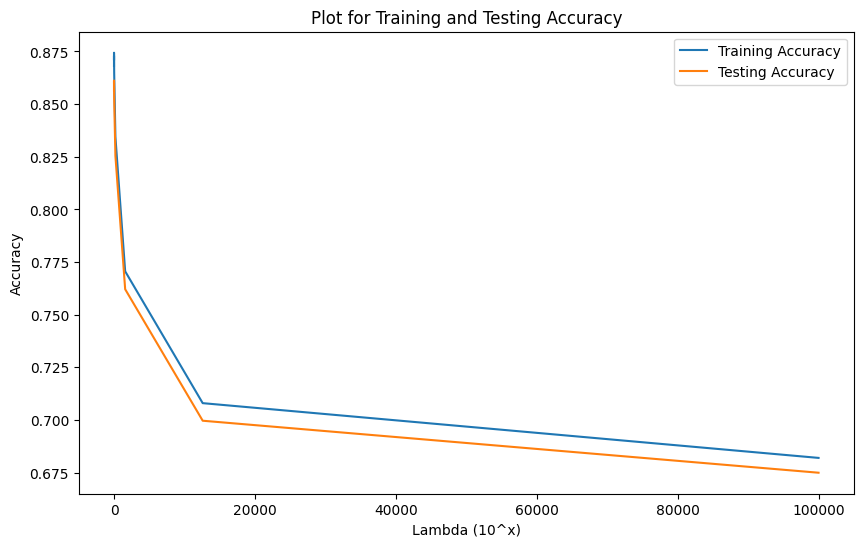

In [9]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X-torch.mean(X, axis=1)[:,None]
X = torch.abs(X)
X = X/torch.linalg.norm(X, axis=1)[:,None]

T = torch.nn.functional.one_hot(mnist.targets).float()

I = torch.eye(784).float()

accuracy_train_arry = []
accuracy_test_arry = []
N = 5000
lambds = np.logspace(-4, 5, 11)

for lambd in lambds:
    W = torch.inverse(X.T @ X + lambd * I) @ (X.T @ T)

    X_train, X_test = X[:N], X[N:] # split X into two parts for training and testing
    T_train, T_test = T[:N], T[N:] # split T into two parts for training and testing

    Y_train = X_train @ W
    Y_test = X_test @ W

    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)).item() / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)).item() / len(Y_test)

    accuracy_train_arry.append(accuracy_train)
    accuracy_test_arry.append(accuracy_test)

# Plots
plt.figure(figsize=(10, 6))
plt.plot(lambds, accuracy_train_arry, label='Training Accuracy')
plt.plot(lambds, accuracy_test_arry, label='Testing Accuracy')
plt.xlabel('Lambda (10^x)')
plt.ylabel('Accuracy')
plt.title('Plot for Training and Testing Accuracy')
plt.legend()
plt.show()

*Question : How does the performance of the network compare to that of 2b) and 2c)?*

Answer : ??


*Question : Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?*

Answer : ????

*Question : Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?*

Answer : ????????

# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)),
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)),
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [18]:
!pip install torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, neurons = 50):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, neurons)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(neurons, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category

network = Net()

In [28]:
# create the learning rule
optimizer = optim.SGD(network.parameters(),
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)),
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)),
                                          batch_size=1000, shuffle=True)

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule

            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)

    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

<ipython-input-27-883ccd5cb438>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 2 Training accuracy: 0.9142000079154968
Iteration 2 Testing accuracy: 0.8966000080108643
Iteration 3 Training accuracy: 0.9229999780654907
Iteration 3 Testing accuracy: 0.9021999835968018
Iteration 4 Training accuracy: 0.9309999942779541
Iteration 4 Testing accuracy: 0.9043999910354614
Iteration 5 Training accuracy: 0.9348000288009644
Iteration 5 Testing accuracy: 0.9057999849319458
Iteration 6 Training accuracy: 0.9408000111579895
Iteration 6 Testing accuracy: 0.9071999788284302
Iteration 7 Training accuracy: 0.9462000131607056
Iteration 7 Testing accuracy: 0.9088000059127808
Iteration 8 Training accuracy: 0.9472000002861023
Iteration 8 Testing accuracy: 0.9089999794960022
Iteration 9 Training accuracy: 0.9508000016212463
Iteration 9 Testing accuracy: 0.9107999801635742
Iteration 10 Training accuracy: 0.9557999968528748
Iteration 10 Testing accuracy: 0.9124000072479248
Iteration 11 Training accuracy: 0.9595999717712402
Iteration 11 Testing accuracy: 0.9133999943733215


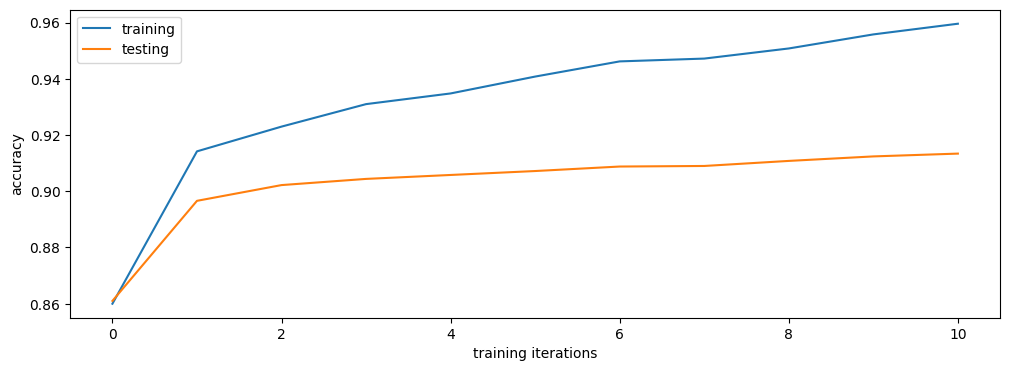

In [30]:
for i in range(10):
    continue_training()
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

*Question : Is this model better or worse than the best models developed in question 2?*

Answer : Yes it is better. The accuracy for both the training data and the testing data are closer to 1.0 compared to Question 2.

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(),
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?


<ipython-input-27-883ccd5cb438>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8593999743461609
Iteration 1 Testing accuracy: 0.8551999926567078
Iteration 2 Training accuracy: 0.901199996471405
Iteration 2 Testing accuracy: 0.8871999979019165
Iteration 3 Training accuracy: 0.9147999882698059
Iteration 3 Testing accuracy: 0.8967999815940857
Iteration 4 Training accuracy: 0.9247999787330627
Iteration 4 Testing accuracy: 0.9003999829292297
Iteration 5 Training accuracy: 0.9291999936103821
Iteration 5 Testing accuracy: 0.9043999910354614
Iteration 6 Training accuracy: 0.9369999766349792
Iteration 6 Testing accuracy: 0.906000018119812
Iteration 7 Training accuracy: 0.9430000185966492
Iteration 7 Testing accuracy: 0.9089999794960022
Iteration 8 Training accuracy: 0.9455999732017517
Iteration 8 Testing accuracy: 0.9114000201225281
Iteration 9 Training accuracy: 0.951200008392334
Iteration 9 Testing accuracy: 0.9129999876022339
Iteration 10 Training accuracy: 0.9544000029563904
Iteration 10 Testing accuracy: 0.9138000011444092
Iteration 1

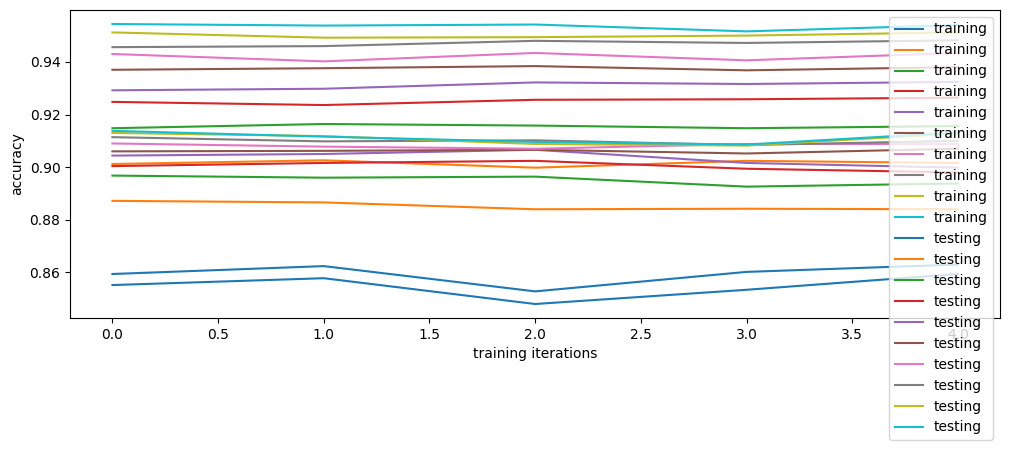

In [31]:

final_accuracy_train = []
final_accuracy_test = []
for run in range(5):
  network = Net()
  optimizer = optim.SGD(network.parameters(),lr=0.1,momentum=0.5)
  accuracy_train = []
  accuracy_test = []
  for i in range(10):
    continue_training()
  final_accuracy_train.append(accuracy_train)
  final_accuracy_test.append(accuracy_test)

plt.figure(figsize=(12,4))
plt.plot(final_accuracy_train, label='training')
plt.plot(final_accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

*Question : Each of the 5 models should show slightly different accuracies. Why is this the case?*

Answer : This is because of the randomness of the data as well as the hidden layer used to build the network and ultimately train the model. As the model gets better, it has learnt from previous iterations and so has a higher accuracy.

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


<ipython-input-32-d99ac4f8532a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.6552000045776367
Iteration 1 Testing accuracy: 0.6679999828338623
Iteration 2 Training accuracy: 0.7928000092506409
Iteration 2 Testing accuracy: 0.771399974822998
Iteration 3 Training accuracy: 0.817799985408783
Iteration 3 Testing accuracy: 0.7928000092506409
Iteration 4 Training accuracy: 0.8343999981880188
Iteration 4 Testing accuracy: 0.8059999942779541
Iteration 5 Training accuracy: 0.849399983882904
Iteration 5 Testing accuracy: 0.8198000192642212
Iteration 6 Training accuracy: 0.8568000197410583
Iteration 6 Testing accuracy: 0.8334000110626221
Iteration 7 Training accuracy: 0.8669999837875366
Iteration 7 Testing accuracy: 0.8414000272750854
Iteration 8 Training accuracy: 0.8772000074386597
Iteration 8 Testing accuracy: 0.8496000170707703
Iteration 9 Training accuracy: 0.8871999979019165
Iteration 9 Testing accuracy: 0.8550000190734863
Iteration 10 Training accuracy: 0.8913999795913696
Iteration 10 Testing accuracy: 0.8586000204086304
Iteration 1

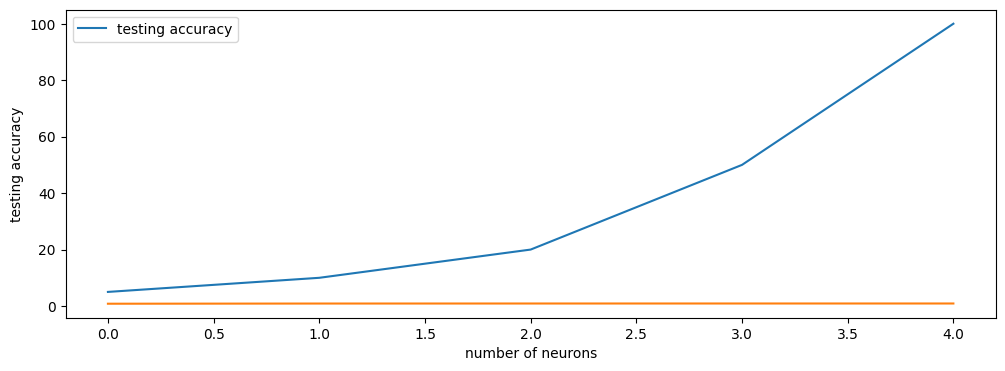

In [36]:
average_accuracies = []
hidden_layer_neuron_set = [5, 10, 20, 50, 100]
for num_neurons in hidden_layer_neuron_set:
  final_accuracy_train = []
  final_accuracy_test = []
  for run in range(5):
    network = Net(num_neurons)
    optimizer = optim.SGD(network.parameters(),lr=0.1,momentum=0.5)
    accuracy_train = []
    accuracy_test = []
    for i in range(10):
      continue_training()
    final_accuracy_train.append(accuracy_train)
    final_accuracy_test.append(accuracy_test)
  average_accuracies.append(np.mean(final_accuracy_test))

plt.figure(figsize=(12,4))
plt.plot(hidden_layer_neuron_set, label='testing accuracy')
plt.plot(average_accuracies)
plt.legend()
plt.xlabel('number of neurons')
plt.ylabel('testing accuracy')
plt.show()

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

<ipython-input-41-adefa0c63a23>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.7803999781608582
Iteration 1 Testing accuracy: 0.8187999725341797
Iteration 2 Training accuracy: 0.9323999881744385
Iteration 2 Testing accuracy: 0.9182000160217285
Iteration 3 Training accuracy: 0.9613999724388123
Iteration 3 Testing accuracy: 0.9380000233650208
Iteration 4 Training accuracy: 0.9714000225067139
Iteration 4 Testing accuracy: 0.9476000070571899
Iteration 5 Training accuracy: 0.9793999791145325
Iteration 5 Testing accuracy: 0.9503999948501587
Iteration 6 Training accuracy: 0.9837999939918518
Iteration 6 Testing accuracy: 0.9508000016212463
Iteration 7 Training accuracy: 0.9900000095367432
Iteration 7 Testing accuracy: 0.9581999778747559
Iteration 8 Training accuracy: 0.9927999973297119
Iteration 8 Testing accuracy: 0.9610000252723694
Iteration 9 Training accuracy: 0.995199978351593
Iteration 9 Testing accuracy: 0.9557999968528748
Iteration 10 Training accuracy: 0.996399998664856
Iteration 10 Testing accuracy: 0.9584000110626221
Iteration 

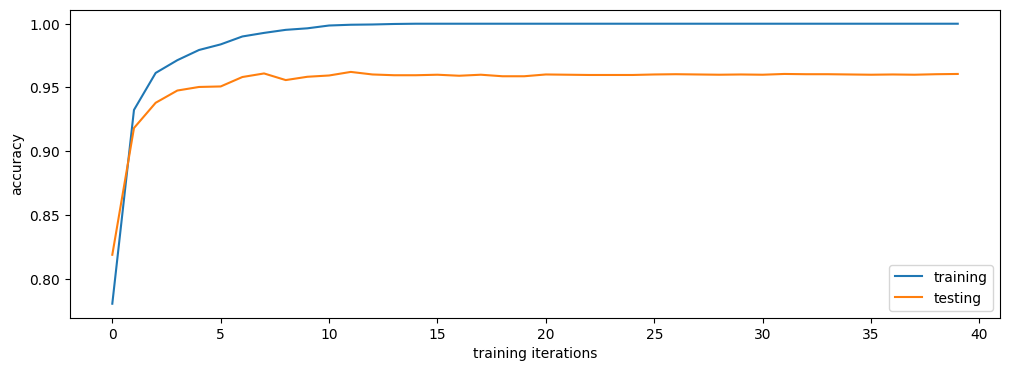

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
optimizer = optim.SGD(network.parameters(),lr=0.1,momentum=0.5)
accuracy_train = []
accuracy_test = []
for i in range(40):
  continue_training()

plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()


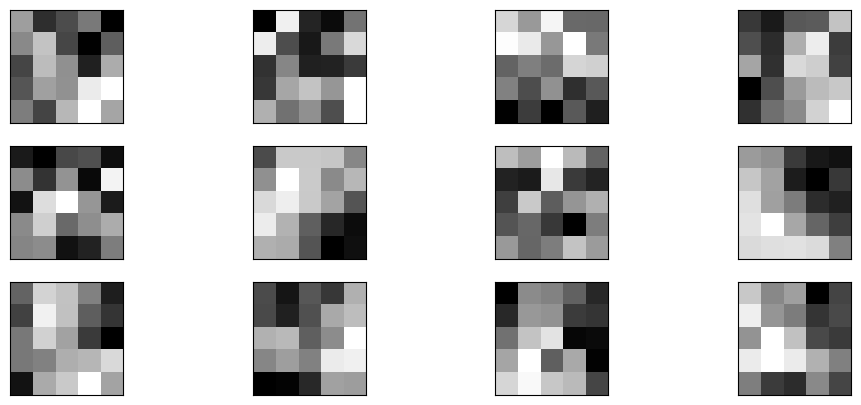

In [42]:
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.